In [59]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [60]:
df=pd.read_csv('drugsComTrain_raw.csv')

In [61]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [62]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [63]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [64]:
df.shape

(161297, 7)

In [65]:
df_train.shape

(42732, 7)

In [66]:
X = df_train.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)

In [67]:
X.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: count, dtype: int64

In [68]:
X.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

In [69]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word cloud for Birth control')

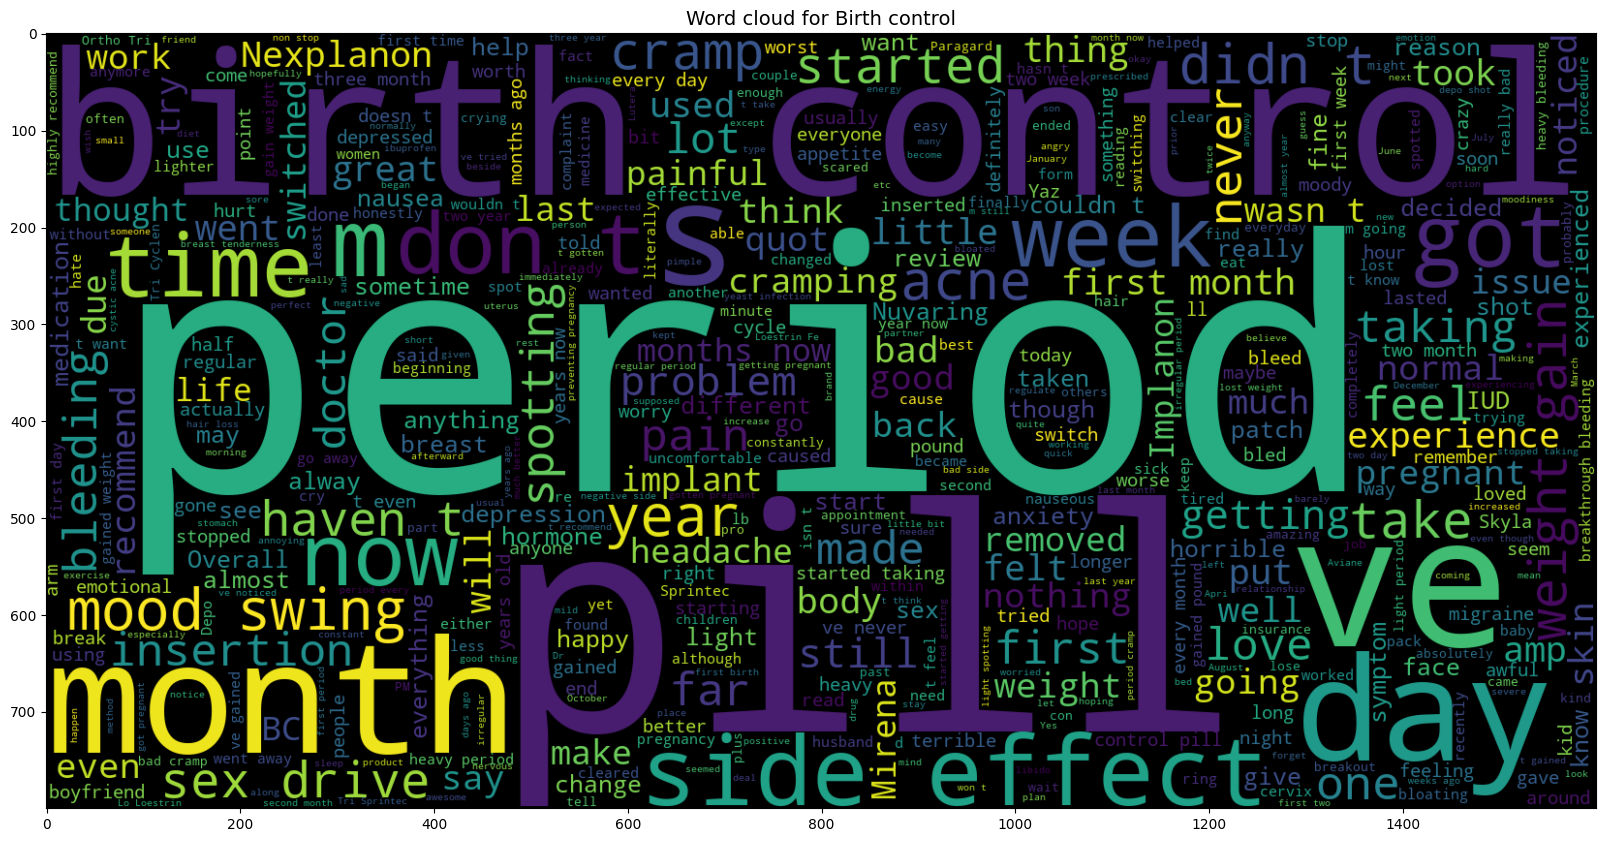

In [70]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_birth.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

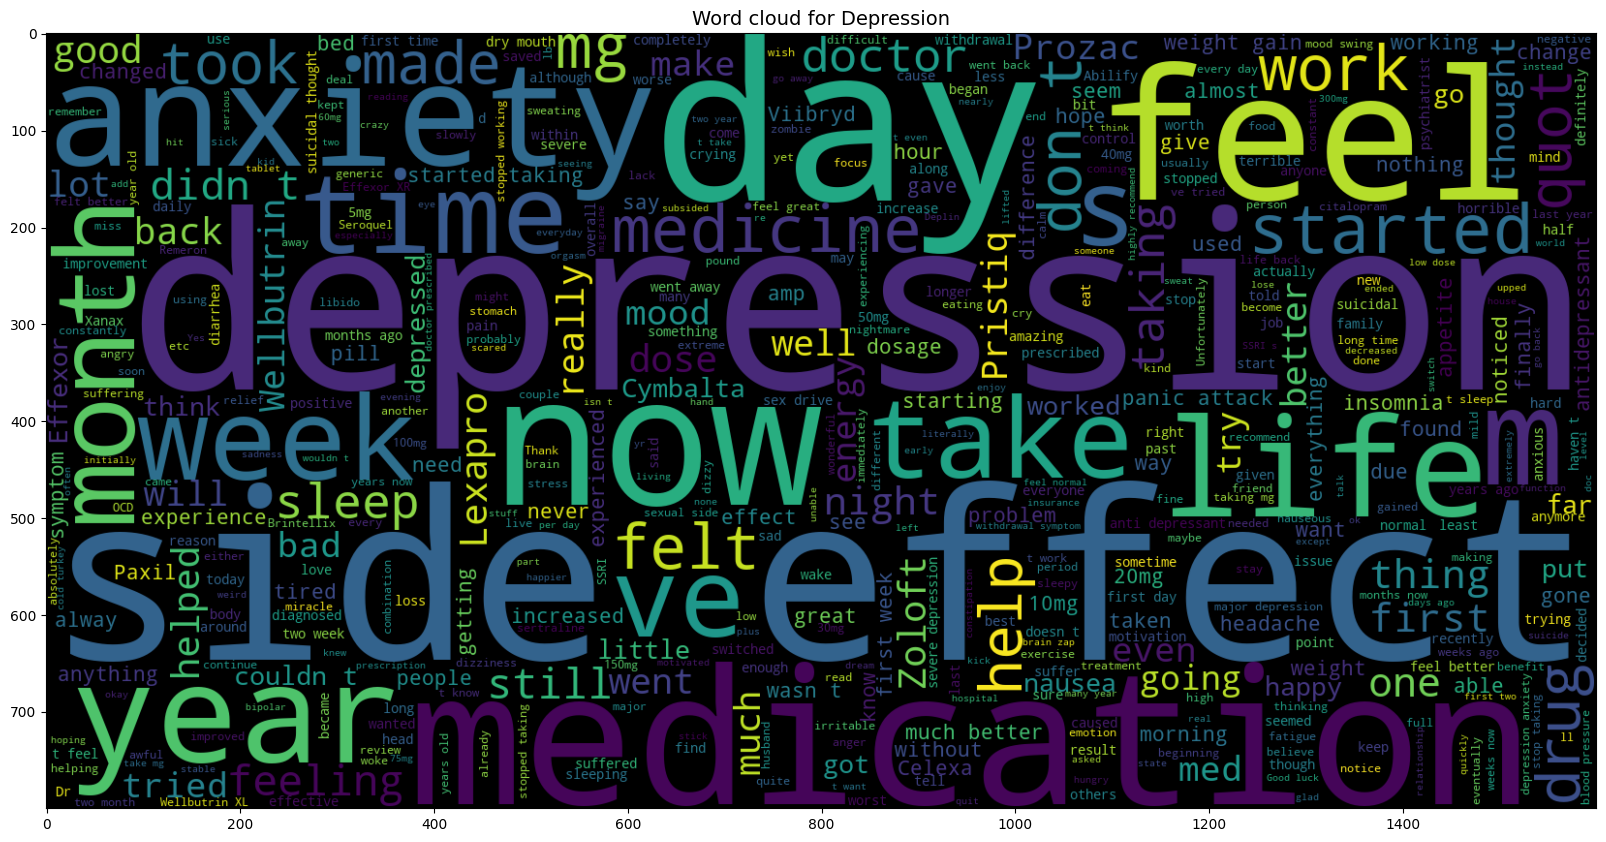

In [71]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

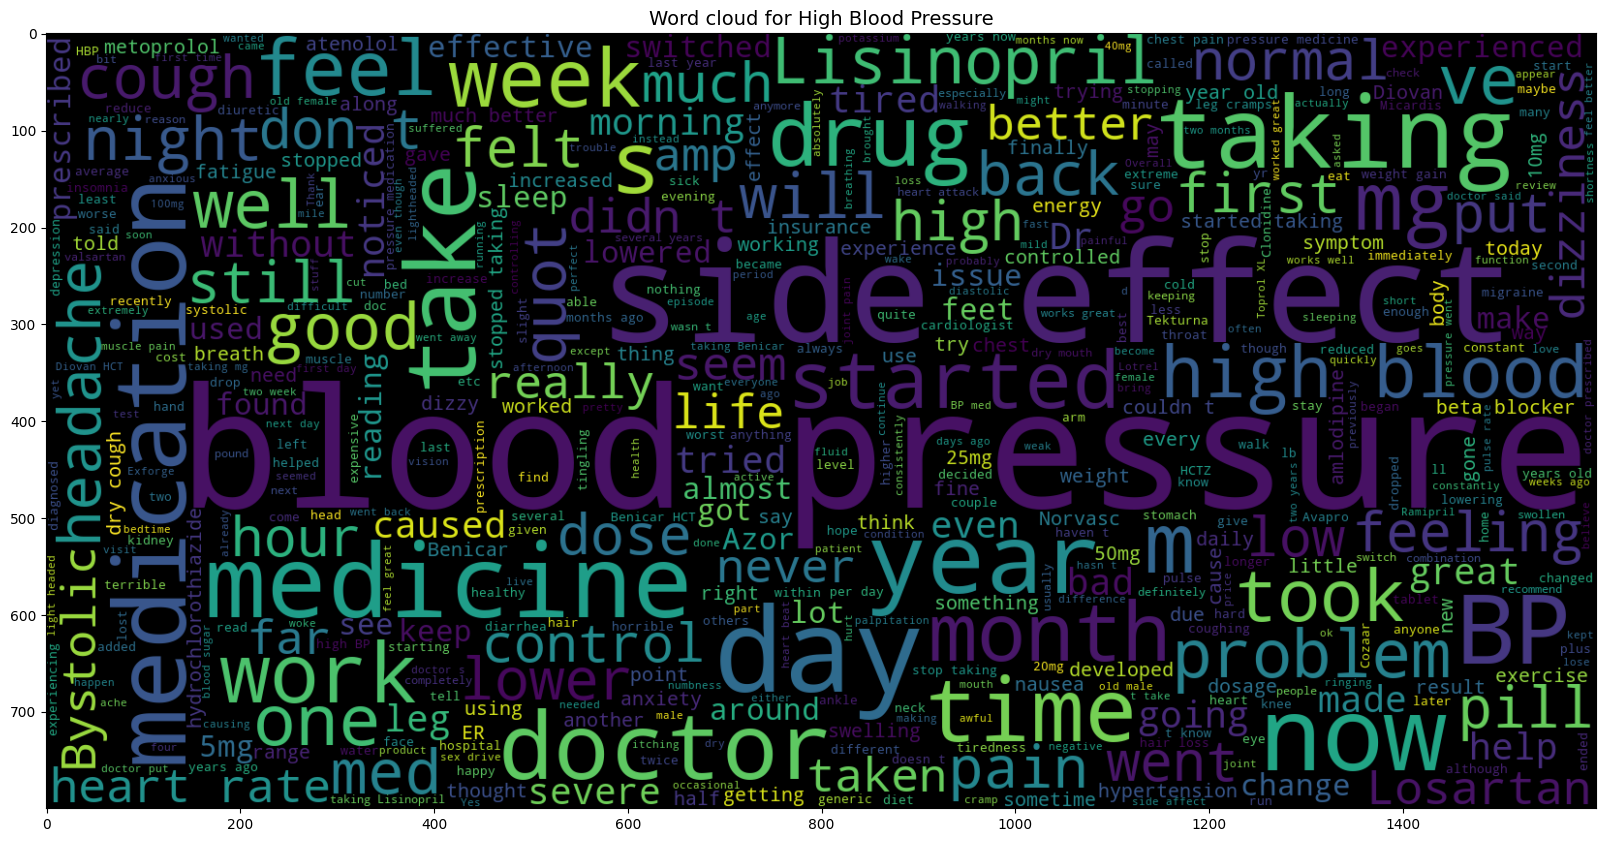

In [72]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

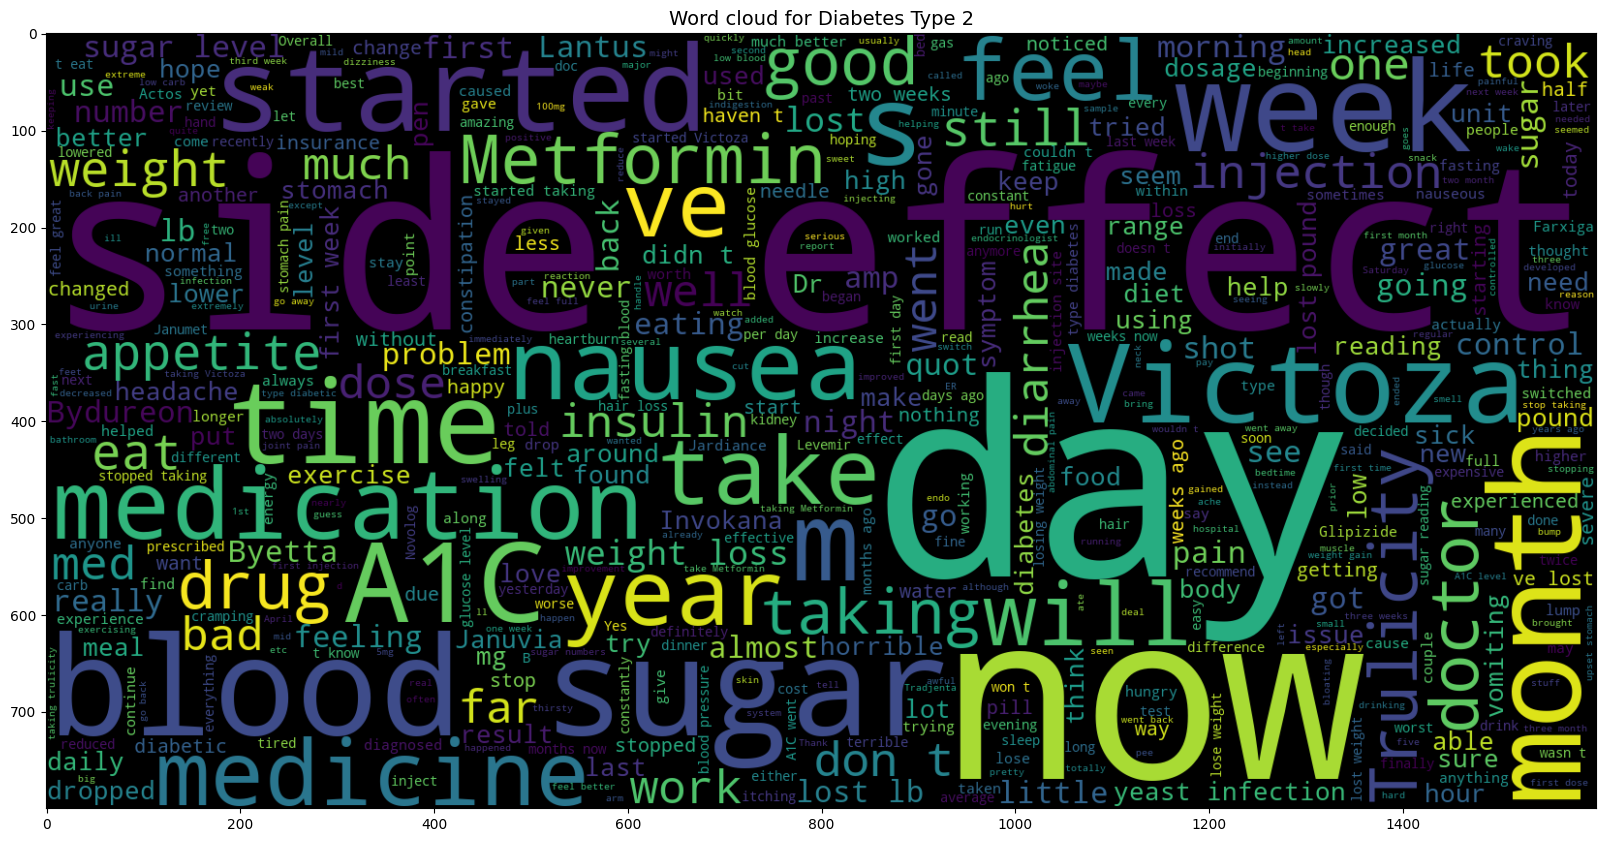

In [73]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

## data preprocessing

In [74]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [75]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [76]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [77]:
X.head()

condition                                             review
2   Birth Control  I used to take another oral contraceptive, whi...
3   Birth Control  This is my first time using any form of birth ...
9   Birth Control  I had been on the pill for many years. When my...
11     Depression  I have taken anti-depressants for years, with ...
14  Birth Control  Started Nexplanon 2 months ago because I have ...

In [78]:
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [79]:
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re

lemmatizer = WordNetLemmatizer()

In [80]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [81]:
X['review_clean'] = X['review'].apply(review_to_words)

/var/folders/75/s0c8bxbn51165ddtycr2p3hh0000gn/T/ipykernel_11170/2066199760.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [82]:
X.head()

condition                                             review  \
2   Birth Control  I used to take another oral contraceptive, whi...   
3   Birth Control  This is my first time using any form of birth ...   
9   Birth Control  I had been on the pill for many years. When my...   
11     Depression  I have taken anti-depressants for years, with ...   
14  Birth Control  Started Nexplanon 2 months ago because I have ...   

                                         review_clean  
2   used take another oral contraceptive pill cycl...  
3   first time using form birth control glad went ...  
9   pill many year doctor changed rx chateal effec...  
11  taken anti depressant year improvement mostly ...  
14  started nexplanon month ago minimal amount con...

## Creating features and Target Variable

In [83]:
X_feat=X['review_clean']
y=X['condition']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Bag of Words

In [86]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [87]:
count_train

<34185x15995 sparse matrix of type '<class 'numpy.int64'>'
	with 1092752 stored elements in Compressed Sparse Row format>

## Machine Learning Model : Naive Bayes

accuracy:   0.970
Confusion matrix, without normalization


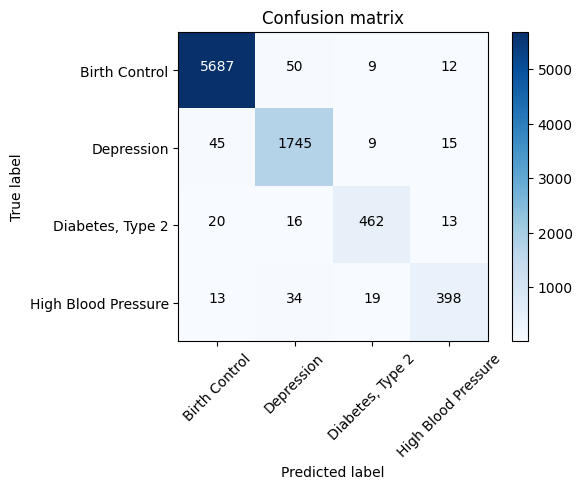

In [88]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model : Passive Aggressive Classifier

accuracy:   0.977
Confusion matrix, without normalization


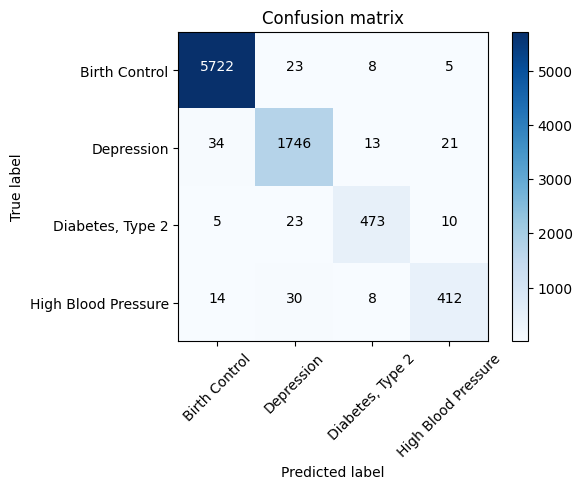

In [89]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### TFIDF

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model : Naive Bayes

accuracy:   0.921
Confusion matrix, without normalization


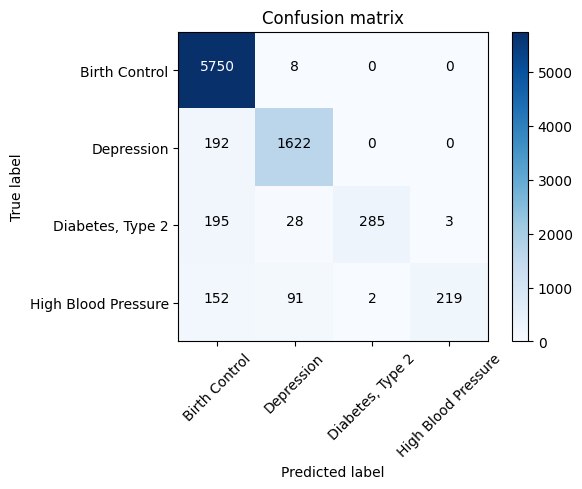

In [91]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model TFIDF

accuracy:   0.981
Confusion matrix, without normalization


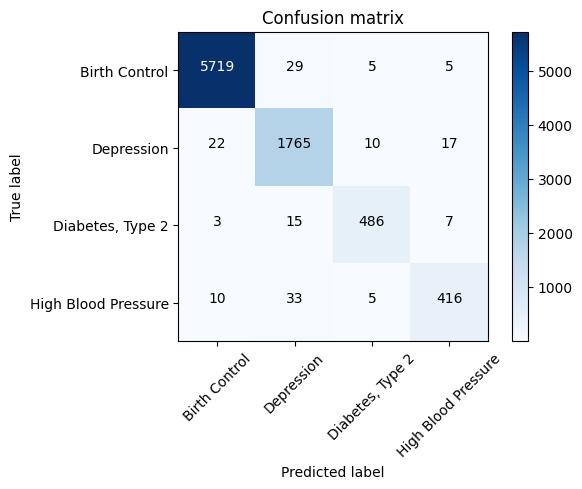

In [92]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])


## TFIDF: Bigrams

In [93]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

accuracy:   0.986
Confusion matrix, without normalization


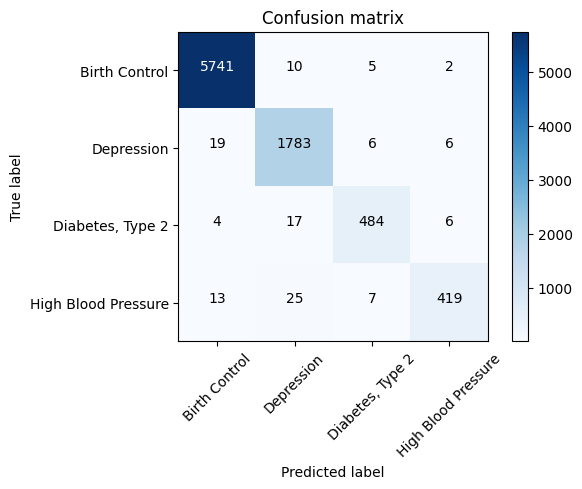

In [94]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF : Trigrams

accuracy:   0.986
Confusion matrix, without normalization


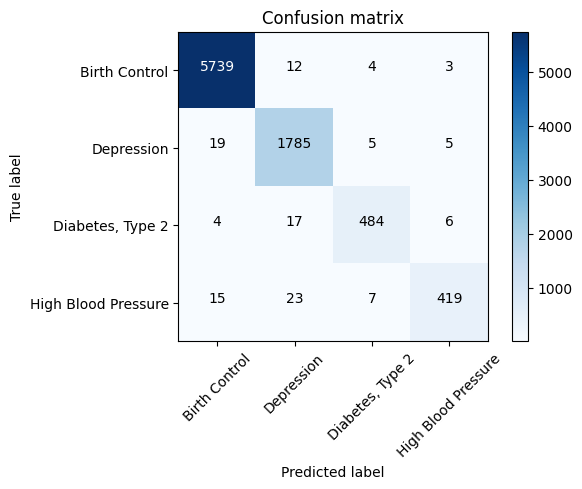

In [95]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Most important Features

In [96]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [52]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [53]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [54]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

## Sample Predictions

In [55]:
X.tail()

condition  \
161273        Birth Control   
161278     Diabetes, Type 2   
161286           Depression   
161290  High Blood Pressure   
161291        Birth Control   

                                                   review  \
161273  I have had the Nexplanon since Dec. 27, 2016 \...   
161278  I just got diagnosed with type 2. My doctor pr...   
161286  This is the third med I&#039;ve tried for anxi...   
161290  I have only been on Tekturna for 9 days. The e...   
161291  This would be my second month on Junel. I&#039...   

                                             review_clean  
161273  nexplanon since dec got first period end janua...  
161278  got diagnosed type doctor prescribed invokana ...  
161286  third med tried anxiety mild depression week h...  
161290  tekturna day effect immediate also calcium cha...  
161291  would second month junel birth control year ch...

In [56]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

ValueError: X has 15995 features, but PassiveAggressiveClassifier is expecting 1085796 features as input.

In [57]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

ValueError: X has 15995 features, but PassiveAggressiveClassifier is expecting 1085796 features as input.

In [58]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

ValueError: X has 15995 features, but PassiveAggressiveClassifier is expecting 1085796 features as input.